### technique route:
1. generate raw dataset: for a selected source, give 32 woveforms of the corresponding the station and then save the data pair order file; 

2. produce the input dataset of the model: produce the waveform data of all corresponding stations by the data pair data, select one target station and produce layout data consists of the vecteors from all stations to the target station, then generate the vector from target station to the source and also save the target station index and its location data of each pair; 

3. normalize the waveform data, target station layout data, label data, and target station log (index and location data); 

   _1-3 are conducted by anothe ipynb file: InputdataProcess_forV6_   
   

4. conduct CNN to get the final vector that represents the vector from target station to the source; 

5. results and analyses 


****************************** 

input1: waveform of wach station 

input2: location of all station - location of selected station 

label: source location - selected station location 
(for training, label = label + 1) 
 
RtargetData: index of selected station, corresponding location 

****************************** 


## 0.  preparation:  import packages

In [2]:
import os
import time
import math
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
import binascii
# from tqdm import tqdm
# from tqdm._tqdm import trange
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data_utils
import random
from myPlotFunction import imagesc
from progress_bar import progress_bar
from highestPowerof2 import highestPowerof2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.summary import summary

### build CNN based model for NewBerry EGS field data

In [23]:
class BlockNewberry(nn.Module):
    def __init__(self, n_channels, unit_channel, n_classes, kernelSize = (3,1), padSize = (4,1), waveLen = 4096, expandFactor = 16):
        super(BlockNewberry, self).__init__()
        self.n_channels = n_channels
        self.unitChannel = unit_channel
        self.n_classes = n_classes
        self.waveLen = waveLen
#         self.bilinear = bilinear
        self.k = kernelSize
        self.expandFactor = expandFactor
        self.expandChannel = self.expandFactor * self.unitChannel
        
        self.Convcompress = nn.Sequential(
            nn.Conv2d(self.unitChannel, self.expandChannel, kernel_size = (7,3), padding = (2,1), stride = (2,1), groups = self.unitChannel),
            nn.BatchNorm2d(self.expandChannel), 
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(self.expandChannel, self.expandChannel, kernel_size = (3,3), padding = (1,1), stride = (2,1), groups = self.unitChannel),
            nn.BatchNorm2d(self.expandChannel), 
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(self.expandChannel, self.expandChannel, kernel_size = (3,3), padding = (1,0), stride = (2,1), groups = self.unitChannel),
            nn.BatchNorm2d(self.expandChannel), 
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(self.expandChannel, self.expandChannel, kernel_size = (3,1), padding = (1,0), stride = (2,1), groups = self.unitChannel),
            nn.BatchNorm2d(self.expandChannel), 
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(self.expandChannel, self.expandChannel, kernel_size = (3,1), padding = (0,0), stride = (2,1), groups = self.unitChannel),
            nn.BatchNorm2d(self.expandChannel), 
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(self.expandChannel, self.expandChannel, kernel_size = (3,1), padding = (0,0), stride = (2,1), groups = self.unitChannel),
            nn.BatchNorm2d(self.expandChannel), 
            nn.LeakyReLU(inplace=True),      
        )
        
        self.Conv_aggreate = nn.Sequential(
            nn.Conv2d(self.expandChannel, self.expandChannel*2, kernel_size = (3,1), padding = (1,0), stride = (1,1)),
#             nn.BatchNorm2d(self.expandChannel*2), 
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(self.expandChannel*2, self.expandChannel*4, kernel_size = (3,1), padding = (0,0), stride = (1,1)),
#             nn.BatchNorm2d(self.expandChannel*4), 
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(self.expandChannel*4, self.expandChannel*8, kernel_size = (3,1), padding = (1,0), stride = (2,1)),
            nn.BatchNorm2d(self.expandChannel*8), 
            nn.LeakyReLU(inplace=True),
        
        )
        
        
        self.mlp = nn.Sequential(
            nn.Linear(48*32*self.expandFactor,2048),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(2048,512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,128),
            nn.LeakyReLU(),
            nn.Linear(128,3),
        )
    def forward(self, input1, input2):
#         print('kernel size is ', self.k, 'padding size is ', self.pad)
#         input1 = inputData[:,:,0:self.waveLen,:]
#         print(input1.size())
#         input2 = inputData[:,:,self.waveLen:,:]
#         print(input2.size())
        x1 = self.Convcompress(input1)
#         print(x1.size())
#         x2_ini = input2
#         the initial input2 size is [32, 3, 1], and we need to expand it to []
        x2 = input2.repeat(1, self.expandFactor, 1, 1)
        x3 = torch.cat((x1, x2), axis = 2)
#         print(x3.size())
        x4 = self.Conv_aggreate(x3)
#         print(x4.size())
        x5 = x4.view(x4.size(0),-1)
#         print(x5.size())
        x_out = self.mlp(x5)
        return x_out

In [14]:
x = torch.randn([6, 3, 1])
print(x)
xx = x.repeat(6, 1, 1)
print(xx.size())
print(xx)

tensor([[[-0.8496],
         [ 0.6085],
         [-2.5144]],

        [[ 0.9922],
         [-2.3262],
         [ 0.3162]],

        [[ 0.7510],
         [ 1.9664],
         [ 0.8864]],

        [[ 1.0715],
         [ 1.2023],
         [-1.7995]],

        [[-2.6126],
         [-1.5357],
         [ 0.5613]],

        [[ 0.1719],
         [ 2.2618],
         [-0.6938]]])
torch.Size([36, 3, 1])
tensor([[[-0.8496],
         [ 0.6085],
         [-2.5144]],

        [[ 0.9922],
         [-2.3262],
         [ 0.3162]],

        [[ 0.7510],
         [ 1.9664],
         [ 0.8864]],

        [[ 1.0715],
         [ 1.2023],
         [-1.7995]],

        [[-2.6126],
         [-1.5357],
         [ 0.5613]],

        [[ 0.1719],
         [ 2.2618],
         [-0.6938]],

        [[-0.8496],
         [ 0.6085],
         [-2.5144]],

        [[ 0.9922],
         [-2.3262],
         [ 0.3162]],

        [[ 0.7510],
         [ 1.9664],
         [ 0.8864]],

        [[ 1.0715],
         [ 1.2023],
       

### set loading data function

In [5]:
import numpy as np
import torch.utils.data as utils_data
class Location_Dataset(utils_data.Dataset):
    def __init__(self, filePath, traceLength, order = None, transform=None):
        self.rawData = np.load(filePath)
        self.traceLength = traceLength
        self.order = order
        self.transform = transform
        self.file_index = self.rawData.files
        self.trace_ind = self.file_index[0]
        self.layout_ind = self.file_index[1]
        self.label_ind = self.file_index[2] 
        self.inputData = self.rawData[self.trace_ind]
        self.layoutData = self.rawData[self.layout_ind]
        self.labelData = self.rawData[self.label_ind]
#         self.len_max = len_max
    def __len__(self):
        if self.order:
            return len(self.order)
        else:
            return self.inputData[self.trace_ind].shape[0]
        
    def __getitem__(self, idx):
        'Generates one sample of data'
        trace_ori = self.inputData[self.order[idx],:,:]
        trace_ = trace_ori[:,:,:]
        layoutData = self.layoutData[self.order[idx],:,:]
        layout_ = layoutData[:,:,np.newaxis]
        labeldata = self.labelData[self.order[idx],:]
        label_ = labeldata
        trace_ = torch.from_numpy(trace_).type(dtype=torch.float32) # input shape [batch_size, 32, 2048, 1]
        label_ = torch.from_numpy(label_).type(dtype=torch.float32) # label shape [batch_size, 3]
        layout_ = torch.from_numpy(layout_).type(dtype=torch.float32) # label shape [batch_size, 32, 3, 1]
        return trace_, layout_, label_
def rollback(data):
    """
    normalize data into new distribution with given mean and std
    """
    max_, min_ = data.max(), data.min()
    data = (data - min_)/(max_ - min_) # regular normalization
    mean_, std_ = data.mean(), data.std() # obtain mean and variance in 0~1
    data = (data - mean_) / std_ * new_std + new_mean # normalization with fixed mean and variance
    return data, (max_, min_, mean_, std_)

In [24]:
import datetime
# input4train_path = 'input_labelNewberry0730.npz'
input4train_path = 'inputLabelNB0526.npz'
traceLength = 4096
len_data = 17802
# len_data = 6400
trainval_ratio = 0.9
# len_max = 10 * np.sqrt((x_index ** 2) + (y_index ** 2) + (z_index ** 2)) not need for the norData
train_number = len_data * trainval_ratio
# index_sample = np.arange(0, len_data)

############### ****** 1. data shuffle options ****** ##################

# ----------------------------------------------------------------------
# option 1) load existing order index ###
index_path = 'orderIndex0730_2021_06_01_14_55_59.npy'
index_sample = np.load(index_path)
# ----------------------------------------------------------------------
# option 2) use new order index      ###
# index_sample = np.arange(len_data)
# np.random.shuffle(index_sample)
# cwd_path = os.getcwd()
# d = datetime.datetime.now()
# current_index_filename = d.strftime("%Y_%m_%d_%H_%M_%S")
# # current_index_filename = '2020_05_27_13_45_23'
# # type(current_index_filename)
# save_pth = cwd_path + '/orderIndex0730_' + current_index_filename
# print(save_pth)
# np.save(save_pth, index_sample)
# print(index_sample.shape)

############### ****** 2. ata selection options ****** #################

# ----------------------------------------------------------------------
# option 1) use the whole data
order_train = index_sample[0:int(train_number)].tolist()
order_val = index_sample[int(train_number):].tolist()
# ----------------------------------------------------------------------
# option 2) use tiny dataset for test
# trainTiny = 0.1 * len_data
# trainVal = trainTiny * 1.1
# order_train = index_sample[0:int(trainTiny)].tolist()
# order_val = index_sample[int(trainTiny):int(trainVal)].tolist()
print(len(order_train), len(order_val))

trainset = Location_Dataset(input4train_path, traceLength, order = order_train, transform = False)
valset = Location_Dataset(input4train_path, traceLength, order = order_val, transform = False)

16021 1781


In [30]:
batchsizeTrain = 128
batchsizeVal = 512
dataloaders_dict = {'train': data_utils.DataLoader(trainset, shuffle=True, batch_size=batchsizeTrain, num_workers = 0,
                                                   worker_init_fn=None),
                    'val': data_utils.DataLoader(valset, shuffle=True, batch_size=batchsizeVal, num_workers = 0,
                                                 worker_init_fn=None)}

In [31]:
count = 0 
for x, y, z in dataloaders_dict['train']:
    print(x.shape,y.shape, z.shape)
#     print(y, z)
#     print(x.shape, x[0,0,2048:,0], y.shape, y[0,0,:,:])
    del x, y, z
    count += 1
    if count > 2: break

torch.Size([128, 6, 4096, 3]) torch.Size([128, 6, 3, 1]) torch.Size([128, 3])
torch.Size([128, 6, 4096, 3]) torch.Size([128, 6, 3, 1]) torch.Size([128, 3])
torch.Size([128, 6, 4096, 3]) torch.Size([128, 6, 3, 1]) torch.Size([128, 3])


In [32]:
######################### model training function #########################
         
import time
import copy
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, timeRecord=False, verbose_train=False, pretrained=None, savedFileName=None, device=None):
    '''
    Parameters
    ----------
    model : model used to generate input, note the number of outputs from model.
    dataloaders : Input dataset_dict, contains "train" and "val".
    criterion: for loss function.
    optimizer: optimizer available from pytorch.
    num_epochs: Maximum epochs for training.
    timeRecord: True, print approximate remaining time after each iteration.
    verbose_train: True, output train_statistic_history too.
    -------
    # MSE: mean squared error
    # MAE: mean absolute error
    # RAE: relative absolute error
    # RRSE: Root relative squared error
    # R2Score: coefficient of determination (r2score)
    '''
    if timeRecord: since = time.time()
    if device is None: device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    if pretrained is None:        
        if verbose_train:
            train_mse_history = [] # this is the loss used
            train_mae_history = []
            train_rae_history = []
            train_rrse_history = []
            train_r2score_history = []
    
        val_mse_history = []
        val_mae_history = []
        val_rae_history = []
        val_rrse_history = []
        val_r2score_history = []

        best_mse_wts = copy.deepcopy(model.state_dict())
        best_mae_wts = copy.deepcopy(model.state_dict())
        best_rae_wts = copy.deepcopy(model.state_dict())
        best_rrse_wts = copy.deepcopy(model.state_dict())
        best_r2score_wts = copy.deepcopy(model.state_dict())
        best_mse = 1.0e+1000
        best_mae = 1.0e+1000
        best_rae = 1.0e+1000
        best_rrse = 1.0e+1000
        best_r2score = 1.0e+1000
        total_epochs = range(num_epochs)
        last_epoch = num_epochs
    else:
        checkpoint = torch.load(savedFileName)
        model.load_state_dict(checkpoint['model_state_dict'])
        statistics_history = checkpoint['statistics_history']
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_model_state_dicts = checkpoint['best_model_state_dicts']
        finied_epochs = checkpoint['num_epochs']
        total_epochs = range(finied_epochs, finied_epochs+num_epochs)
        last_epoch = finied_epochs+num_epochs
        if verbose_train:
            train_statistics_history = statistics_history[0]
            val_statistics_history = statistics_history[1]
            train_mse_history = train_statistics_history[0]
            train_mae_history = train_statistics_history[1]
            train_rae_history = train_statistics_history[2]
            train_rrse_history = train_statistics_history[3]
            train_r2score_history = train_statistics_history[4]
        else:
            val_statistics_history = statistics_history
            
        val_mse_history = val_statistics_history[0]
        val_mae_history = val_statistics_history[1]
        val_rae_history = val_statistics_history[2]
        val_rrse_history = val_statistics_history[3]
        val_r2score_history = val_statistics_history[4]
            
        best_mse_wts = best_model_state_dicts[0]
        best_mae_wts = best_model_state_dicts[1]
        best_rae_wts = best_model_state_dicts[2]
        best_rrse_wts = best_model_state_dicts[3]
        best_r2score_wts = best_model_state_dicts[4]
        best_mse = best_model_state_dicts[5]
        best_mae = best_model_state_dicts[6]
        best_rae = best_model_state_dicts[7]
        best_rrse = best_model_state_dicts[8]
        best_r2score = best_model_state_dicts[9]
    
    best_epoch_mse_num = None
    best_epoch_mae_num = None
    best_epoch_rae_num = None
    best_epoch_rrse_num = None
    best_epoch_r2score_num = None
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=20, verbose=False, threshold=1e-6, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
    for epoch in total_epochs:
        print('-' * 10)
        if epoch!=0 and timeRecord:
            print('Epoch {}/{}: '.format(epoch+1, total_epochs[-1]+1), end='')
            progress_bar(epoch, total_epochs[-1]+1, since, showTimeOnly=True)
        else:
            print('Epoch {}/{}'.format(epoch+1, total_epochs[-1]+1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_mae = 0.0
            running_rae = 0.0
            running_rrse = 0.0
            running_r2score = 0.0
                        
            # Iterate over data.
            for input1, input2, labels in dataloaders[phase]:
                input1 = input1.to(device)
                input2 = input2.to(device)
                labels = (labels + 1).to(device)
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    preds = model(input1, input2)
                    loss = criterion(preds, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # error_mse = loss # if criterion is MSEloss(reduction='mean'), loss is mse
                                 # else: error_mse = error_stat(labels, preds, 'MSE')                 
                error_mae = error_stat(labels.cpu(), preds.detach().cpu(), 'MAE')
                error_rae = error_stat(labels.cpu(), preds.detach().cpu(), 'RAE')
                error_rrse = error_stat(labels.cpu(), preds.detach().cpu(), 'RRSE')
                error_r2score = error_stat(labels.cpu(), preds.detach().cpu(), 'R2Score')

                # statistics
                sampleNum = labels.size(0) * labels.size(1)
                running_loss += loss.item() * sampleNum
                running_mae  += error_mae.item() * sampleNum
                running_rae  += error_rae.item() * sampleNum
                running_rrse += error_rrse.item() * sampleNum
                running_r2score += error_r2score.item() * labels.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_mae  = running_mae / len(dataloaders[phase].dataset)
            epoch_rae  = running_rae / len(dataloaders[phase].dataset)
            epoch_rrse = running_rrse / len(dataloaders[phase].dataset)
            epoch_r2score = running_r2score / len(dataloaders[phase].dataset)
            
            if epoch % 10 == 9:
                print('{} Loss(MSE): {:.4e} MAE: {:.4e} RAE: {:.4e} RRSE: {:.4e} R2: {:.4e} '.format(phase, epoch_loss, epoch_mae, epoch_rae, epoch_rrse, epoch_r2score))

#             deep copy the model
            if phase == 'val' and epoch_loss < best_mse:
                best_mse = epoch_loss
                best_epoch_mse_num = epoch + 1
                best_mse_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_mae < best_mae:
                best_mae = epoch_mae
                best_epoch_mae_num = epoch + 1
                best_mae_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_rae < best_rae:
                best_rae = epoch_rae
                best_epoch_rae_num = epoch + 1
                best_rae_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_rrse < best_rrse:
                best_rrse = epoch_rrse
                best_epoch_rrse_num = epoch + 1
                best_rrse_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and abs(epoch_r2score-1) < abs(best_r2score-1):
                best_r2score = epoch_r2score
                best_epoch_r2score_num = epoch + 1
                best_r2score_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_mse_history.append(epoch_loss)
                val_mae_history.append(epoch_mae)
                val_rae_history.append(epoch_rae)
                val_rrse_history.append(epoch_rrse)
                val_r2score_history.append(epoch_r2score)
            elif verbose_train:
                train_mse_history.append(epoch_loss)
                train_mae_history.append(epoch_mae)
                train_rae_history.append(epoch_rae)
                train_rrse_history.append(epoch_rrse)
                train_r2score_history.append(epoch_r2score)
#             scheduler.step(best_mse)
    time_elapsed = time.time() - since
#             if epoch % 100 == 0:
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val MSE: {:4f} at epoch: {}'.format(best_mse, best_epoch_mse_num))
    print('Best val MAE: {:4f} at epoch: {}'.format(best_mae, best_epoch_mae_num))
    print('Best val RAE: {} at epoch: {}'.format(best_rae, best_epoch_rae_num))
    print('Best val RRSE: {} at epoch: {}'.format(best_rrse, best_epoch_rrse_num))
    print('Best val R2Score: {} at epoch: {}'.format(best_r2score, best_epoch_r2score_num))

    val_statistics_history = [val_mse_history, val_mae_history, val_rae_history, val_rrse_history, val_r2score_history]
    best_model_state_dicts = [best_mse_wts, best_mae_wts, best_rae_wts, best_rrse_wts, best_r2score_wts, best_mse, best_mae,
                              best_rae, best_rrse, best_r2score]
    if verbose_train:
        train_statistics_history = [train_mse_history, train_mae_history, train_rae_history, train_rrse_history,
                                    train_r2score_history]
        statistics_history = [train_statistics_history, val_statistics_history]
    else:
        statistics_history = val_statistics_history
    
    # load best model weights
    model.load_state_dict(best_mse_wts)
#     print('best mae error is in epoch ', )
    return model, statistics_history, best_model_state_dicts, last_epoch

def error_stat(y_true, y_pred, name='MSE'):
    """
    This function calculates statistical errors by given name
    y_true: a tensor, the 1st dimension represents the batch size
    y_pred: a tensor, corresponding to y_true
    ---------------
    name(Optional):    
    ---------------
        # MSE: mean squared error
        # MAE: mean absolute error
        # RAE: relative absolute error
        # RRSE: Root relative squared error
        # R2Score: coefficient of determination (r2score)
    """

    y_trueTR = y_true.view(y_true.size(0), -1).transpose(1,0) # Now, the 1st dimension represents num_samples,
#     and 2nd dimension represent batch_size
    y_predTR = y_pred.view(y_pred.size(0), -1).transpose(1,0)
    
    if name=='MSE':
        error = mean_squared_error(y_trueTR.view(-1), y_predTR.view(-1))
    elif name=='MAE':
        error = mean_absolute_error(y_trueTR, y_predTR, multioutput='uniform_average')
    elif name=='RAE':
        error_abs = torch.abs(y_trueTR - y_predTR).sum(dim=[0])
        error = torch.mean((error_abs / torch.abs(y_trueTR - y_trueTR.mean(dim=[0])).sum(dim=[0])))
    elif name=='RRSE':
        error_square = torch.pow(y_trueTR - y_predTR, 2).sum(dim=[0])
        error = torch.sqrt((error_square / torch.pow(y_trueTR - y_trueTR.mean(dim=[0]), 2).sum(dim=[0]))).mean()
    elif name=='R2Score':
        error = r2_score(y_trueTR, y_predTR, multioutput='uniform_average')
    
    return error

def Func_waveNorm(x):
    '''
    use this function to noemalize the waveform data
    the dimension of input x is: batchsize X (wave+3)
    '''
    x_numpy = x.numpy()
    wavePoints = x_numpy.shape[2]-3
    batchNum = x_numpy.shape[0]
    wave_tonNormalize = x_numpy[:,:,0:wavePoints,:]
    scaleMax = wave_tonNormalize.max(axis = 2)
    scaleMax = np.max(scaleMax, axis = 1)
    scaleMin = wave_tonNormalize.min(axis = 2)
    scaleMin = np.max(scaleMin, axis = 1)
#     print(scaleMax.shape)
    for batchIter in range(batchNum):
        tmpMax = scaleMax[batchIter,0]
        tmpMin = scaleMin[batchIter,0]
        x_numpy[batchIter,:,0:wavePoints,:] = (wave_tonNormalize[batchIter,:,:,:] - tmpMin)/(tmpMax - tmpMin)
    x_numpy[:,:,wavePoints:,:] = x_numpy[:,:,wavePoints:,:]/120
#     print(x_numpy[0,:,wavePoints:,:])
    x_out = torch.from_numpy(x_numpy)
    return x_out

In [33]:
num_epochs = 1000
optim = 'Adam'
# optim = 'SGD'
# global learning_rate
# scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
learning_rate = 1e-4
# k0 = 32
# nereulNum = k0 * 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = DLmodel(inChannel=1, k = k0, traceLength=2048).to(device)
# model = Blockmain(n_channels=3, unit_channel = 32, kernelSize = (3,3), padSize = (1,1), waveLen = 2048, LinearIput = 8192*2, LinearOutput = 3).to(device)
# model = Block0(n_channels=32, unit_channel = 32, n_classes = 32, kernelSize = (3,3), padSize = (1,1), waveLen = 2048).to(device)
model = BlockNewberry(n_channels=6, unit_channel = 6, n_classes = 6, kernelSize = (3,3), padSize = (1,1), waveLen = 2048, expandFactor = 16).to(device)
if optim=="Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optim=="SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

criterion = torch.nn.MSELoss(reduction='mean')
# criterion = torch.nn.L1Loss(reduction='mean')
########################################################################
## if we use pretrain parameters, uncomment the line next to this     ##
## block  load the pretrain data and set a new sanfileName to save t  ##
## he new training parameters                                         ##
########################################################################
# import pretrained model
# pretrain_model = 'modelv6_ADAMTinyData0609NorLossepoch_1000'
# savedFileName = 'modelv6_ADAM0610NorLossepoch_1000'
# savedFileName = 'modelv6_SGD0610NorLossepoch_1000'

savedFileName = 'modelNB_ADAM0601Epoch_1000'

In [36]:
# run the training function
model, val_hist, best_model_state_dicts, last_epoch = train_model(model, dataloaders_dict, criterion, optimizer, 
                                                                  num_epochs=num_epochs, timeRecord=True, 
                                                                  verbose_train=True, pretrained=None, 
                                                                  savedFileName=savedFileName, device=device)

----------
Epoch 1/1000
----------
----------
Epoch 2/1000: Time Elapsed: 3m42.8s, Remaining: 3712m59.6s
----------


KeyboardInterrupt: 

In [22]:
# run the training function
model, val_hist, best_model_state_dicts, last_epoch = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, timeRecord=True, verbose_train=True, pretrained=None, savedFileName=savedFileName, device=None)

----------
Epoch 1/1000
----------


NotImplementedError: 

In [ ]:
# savedFileName = 'modelNB_ADAM0803Epoch_1000'

In [21]:
CSVsavedFileName = 'modelNB_ADAM0804Epoch_'
import pandas as pd
val_sta = np.array(val_hist)
valHist_df = pd.DataFrame({'MSE_train':val_sta[0,0,:],'MAE_train':val_sta[0,1,:],'RAE_train':val_sta[0,2,:],
                           'RRSE_train':val_sta[0,3,:],'R2_train':val_sta[0,4,:],
                           'MSE_val':val_sta[1,0,:],'MAE_val':val_sta[1,1,:],'RAE_val':val_sta[1,2,:],
                           'RRSE_val':val_sta[1,3,:],'R2_val':val_sta[1,4,:]})
csvFile = 'valHistv6_' + CSVsavedFileName + str(last_epoch) + '.csv'
valHist_df.to_csv(csvFile, index=True, sep=',')

In [22]:
# save model_dict
modelFileName = "modelNB_ADAM0804Epoch_" + str(last_epoch)
print(modelFileName)
torch.save({
            'num_epochs': last_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'statistics_history': val_hist, 
            'best_model_state_dicts': best_model_state_dicts
            }, modelFileName)

modelNB_ADAM0804Epoch_1000


Index(['MSE_train', 'MAE_train', 'RAE_train', 'RRSE_train', 'R2_train',
       'MSE_val', 'MAE_val', 'RAE_val', 'RRSE_val', 'R2_val'],
      dtype='object')
statisticsSummary_modelNB_ADAM0804Epoch_1000.png


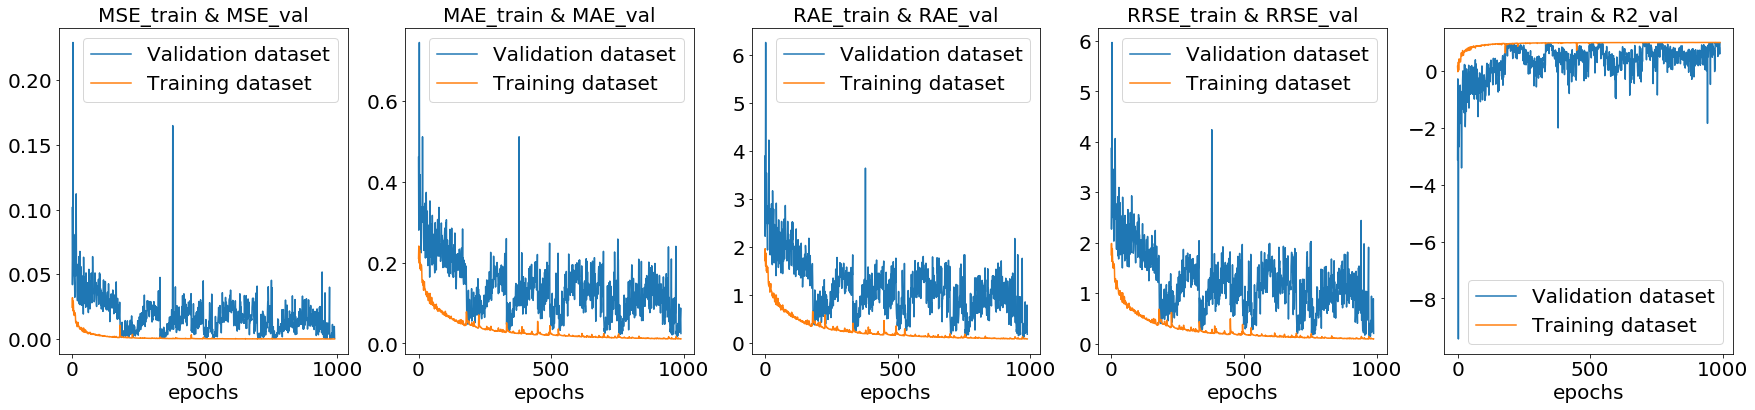

In [23]:
import pandas as pd
val_staindex = pd.read_csv(csvFile)
index_list = val_staindex.columns[1:]
print(index_list)
val_staindex = np.array(val_staindex)[:,1:]
h = 1
k = 5
t = 1000
t_ini = 10
t_term = last_epoch
fig, axs = plt.subplots(h,k, figsize=(30, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
# fig = plt.figure(figsize=(16, 16))
font2 = {'weight': 'normal',
         'size': 20,
         }
for i in range(h):
    for j in range(k):
        subIndex = i * k + j
#         print(i, j, subIndex)
        axs[subIndex].plot(range(t_term - t_ini), val_staindex[t_ini: t_term,j+5], label = 'Validation dataset')
        axs[subIndex].plot(range(t_term - t_ini), val_staindex[t_ini: t_term,j], label = 'Training dataset')
        title_list = str(index_list[j]) + ' & ' + str(index_list[j+5])
        axs[subIndex].set_title(title_list, font2)
        axs[subIndex].set_xlabel('epochs', font2)
        axs[subIndex].tick_params(labelsize=20)
        axs[subIndex].legend(prop=font2)
# fig = plt.gcf()
model_name = modelFileName
figureTitle = 'statisticsSummary' + '_' + model_name + '.png'
print(figureTitle)
plt.savefig(figureTitle, bbox_inches='tight', dpi=1000)
plt.show()

In [46]:
num_epochs = 600
optim = 'Adam'
# optim = 'SGD'
# global learning_rate
learning_rate = 1e-5
# nereulNum = k0 * 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BlockNewberry(n_channels=6, unit_channel = 6, n_classes = 6, kernelSize = (3,3), padSize = (1,1), waveLen = 2048, expandFactor = 16).to(device)
if optim=="Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optim=="SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

criterion = torch.nn.MSELoss(reduction='mean')
# criterion = torch.nn.L1Loss(reduction='mean')
########################################################################
## if we use pretrain parameters, uncomment the line next to this     ##
## comment load the pretrain data and set a new sanfileName to save t ##
## he new training parameters                                         ##
########################################################################
# pretrain_model = 'modelv6_ADAM0610NorLossEpoch_1000'
pretrain_model = modelFileName
print(pretrain_model)
# savedFileName = pretrain_model

modelNB_ADAM0801Epoch_800


In [47]:
# Train and evaluat（Adam, lr=1e-3）epoch 1-20, Time=True, Dropout=False, bridge(False), depth=4, wf=5, 
# k_size_conv = [5, 5], k_size_pool = [[2, 2], [2, 2], [2, 2]]
model, val_hist, best_model_state_dicts, last_epoch = train_model(model, dataloaders_dict, criterion, optimizer, 
                                                                  num_epochs=num_epochs, timeRecord=True, 
                                                                  verbose_train=True, pretrained=True, 
                                                                  savedFileName=pretrain_model, device=device)

----------
Epoch 801/1400: Time Elapsed: 0m1.1s, Remaining: 0m0.8s
----------
----------
Epoch 802/1400: Time Elapsed: 0m27.5s, Remaining: 0m20.6s
----------
----------
Epoch 803/1400: Time Elapsed: 0m53.9s, Remaining: 0m40.3s
----------
----------
Epoch 804/1400: Time Elapsed: 1m20.5s, Remaining: 0m60.0s
----------
----------
Epoch 805/1400: Time Elapsed: 1m47.3s, Remaining: 1m19.7s
----------
----------
Epoch 806/1400: Time Elapsed: 2m14.0s, Remaining: 1m39.2s
----------
----------
Epoch 807/1400: Time Elapsed: 2m40.7s, Remaining: 1m58.7s
----------
----------
Epoch 808/1400: Time Elapsed: 3m7.5s, Remaining: 2m18.0s
----------
----------
Epoch 809/1400: Time Elapsed: 3m34.3s, Remaining: 2m37.3s
----------
----------
Epoch 810/1400: Time Elapsed: 4m1.1s, Remaining: 2m56.4s
----------
train Loss(MSE): 2.0379e-04 MAE: 1.7690e-02 RAE: 1.3981e-01 RRSE: 1.4549e-01 R2: 9.9410e-01 
val Loss(MSE): 1.1744e-02 MAE: 9.5213e-02 RAE: 8.9401e-01 RRSE: 9.7247e-01 R2: 4.7156e-01 
----------
Epoch 811

In [48]:
CSVsavedFileName = 'modelNB_ADAM0801Epoch_'
import pandas as pd
val_sta = np.array(val_hist)
valHist_df = pd.DataFrame({'MSE_train':val_sta[0,0,:],'MAE_train':val_sta[0,1,:],'RAE_train':val_sta[0,2,:],
                           'RRSE_train':val_sta[0,3,:],'R2_train':val_sta[0,4,:],
                           'MSE_val':val_sta[1,0,:],'MAE_val':val_sta[1,1,:],'RAE_val':val_sta[1,2,:],
                           'RRSE_val':val_sta[1,3,:],'R2_val':val_sta[1,4,:]})
csvFile = 'valHistv6_' + CSVsavedFileName + str(last_epoch) + '.csv'
valHist_df.to_csv(csvFile, index=True, sep=',')

In [49]:
# save model_dict
modelFileName = "modelNB_ADAM0801Epoch_" + str(last_epoch)
print(modelFileName)
torch.save({
            'num_epochs': last_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'statistics_history': val_hist, 
            'best_model_state_dicts': best_model_state_dicts
            }, modelFileName)

modelNB_ADAM0801Epoch_1400


### 3.3 results and plot

In [25]:
rawdata_path = 'fieldDatapair0729_nor.npz'
dataRaw = np.load(rawdata_path)
fileList = dataRaw.files
print(fileList)
rawPosit = dataRaw[fileList[1]]
rSta_ori = rawPosit[:,:,3:6]
rSta = rSta_ori.reshape(rSta_ori.shape[0] * rSta_ori.shape[1], -1)
scaleData = dataRaw[fileList[2]]
print(scaleData, rawPosit.shape, rSta.shape)
# print(rawPosit[7:47,:,:])
srcLable = rawPosit[:,:,0:3].reshape(rawPosit.shape[0]*rawPosit.shape[1], -1)
print(srcLable.shape)

['rawWave', 'rawPosit', 'scaleData']
[[  43.67    43.765]
 [-121.379 -121.22 ]
 [  -1.5      5.1  ]] (2967, 6, 6) (17802, 3)
(17802, 3)


In [9]:
import datetime
# rawdata_path =  r'rawData_2020_03_11_11_54_20.npz'
##### new tiny dataset for test #####
# rawdata_path = r'rawData0326.npz'
rawdata_path = 'input_labelNewberry0730.npz'
traceLength = 4096
len_data = 17802
# len_data = 6400
trainval_ratio = 0.9
# len_max = 10 * np.sqrt((x_index ** 2) + (y_index ** 2) + (z_index ** 2)) not need for the norData
train_number = len_data * trainval_ratio
index_sample = np.arange(len_data)
###### ******1****** ######
# data shuffle options
########################################################################
# option 1) load existing order index ###

index_path = 'orderIndex0730_2020_08_04_15_49_26.npy'
index_sample = np.load(index_path)
########################################################################
# option 2) use new order index      ###
# index_sample = np.arange(len_data)
# np.random.shuffle(index_sample)
# cwd_path = os.getcwd()
# d = datetime.datetime.now()
# current_index_filename = d.strftime("%Y_%m_%d_%H_%M_%S")
# current_index_filename = '2020_05_27_13_45_23'
# type(current_index_filename)
# save_pth = cwd_path + '/orderIndex0603_' + current_index_filename
# print(save_pth)
# np.save(save_pth, index_sample)
# print(index_sample.shape)

###### ******2****** ######
# data selection options
########################################################################
# option 1) use the whole data
order_train = index_sample[0:int(train_number)].tolist()
order_val = index_sample[int(train_number):].tolist()
########################################################################
# option 2) use tiny dataset for test
# trainTiny = 0.1 * len_data
# trainVal = trainTiny * 1.1
# order_train = index_sample[0:int(trainTiny)].tolist()
# order_val = index_sample[int(trainTiny):int(trainVal)].tolist()
print(len(order_train), len(order_val))
trainpred = Location_Dataset(rawdata_path, traceLength, order = order_train, transform = False)
valpred = Location_Dataset(rawdata_path, traceLength, order = order_val, transform = False)

17802 0


In [10]:
batch_size = 256
dataloaders_dict_predTrain = data_utils.DataLoader(trainpred, shuffle=None, batch_size=batch_size, num_workers = 0, worker_init_fn=None)
dataloaders_dict_predVal = data_utils.DataLoader(valpred, shuffle=None, batch_size=batch_size, num_workers = 0, worker_init_fn=None)

In [11]:
def predict_model(model, dataloaders_pred, savedFileName):
        checkpoint = torch.load(savedFileName)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        it = 0
        for input1, input2, labels in dataloaders_pred:
            it = it + 1
            input1 = input1.to(device)
            input2 = input2.to(device)            
            preds_tmp = model(input1, input2)
            preds_tmp = preds_tmp.data.cpu()
            predTmp = preds_tmp.numpy()
            del preds_tmp
            if it == 1:
                pred = predTmp
                label = labels
            else:
                pred = np.concatenate((pred, predTmp), axis = 0)
                label = np.concatenate((label, labels), axis = 0)
        return pred, label

In [12]:
model = BlockNewberry(n_channels=6, unit_channel = 6, n_classes = 6, kernelSize = (3,3), padSize = (1,1), waveLen = 4096, expandFactor = 16).to(device)
# import the model file: modelFileName (name of the model file saved in the previous section)
# modelFileName = 'modelv6_ADAMTinyData0601NorLossEpoch_1000'
dataloaders_dict_pred = dataloaders_dict_predTrain
# modelFileName = 'modelv6_ADAM0611NorLossEpoch_600'
modelFileName = 'modelNB_ADAM0804Epoch_1000'
predTrain, labelTrain = predict_model(model, dataloaders_dict_pred, modelFileName)
print(predTrain.shape, labelTrain.shape)

(17802, 3) (17802, 3)


In [14]:
model = BlockNewberry(n_channels=6, unit_channel = 6, n_classes = 6, kernelSize = (3,3), padSize = (1,1), waveLen = 4096, expandFactor = 16).to(device)
# import the model file: modelFileName (name of the model file saved in the previous section)
modelFileName = 'modelNB_ADAM0804Epoch_1000'
dataloaders_dict_pred = dataloaders_dict_predVal
predVal, labelVal = predict_model(model, dataloaders_dict_pred, modelFileName)
# print(predVal.shape, labelVal.shape)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [13]:
importData = np.load(rawdata_path)
importList = importData.files
print(importList)
labelData = importData[importList[2]]
print(labelData.shape)
srcData = predTrain - 1 + rSta
print(srcData.shape)

['input1', 'input2', 'label']
(17802, 3)
(17802, 3)


In [15]:
import copy
print(scaleData.shape)
lanMin, lanMax = scaleData[0,0], scaleData[0,1]
lngMin, lngMax = scaleData[1,0], scaleData[1,1]
dpthMin, dpthMax = scaleData[2,0], scaleData[2,1]
print(lanMin, lanMax, lngMin, lngMax, dpthMin, dpthMax)
srcDataTrue = copy.deepcopy(srcData)
srcDataTrueE, srcDataTrueN, srcDataTrueZ = srcDataTrue[:,0], srcDataTrue[:,1], srcDataTrue[:,2]
srcDataTrue[:,0] = srcDataTrueE*(lanMax - lanMin) + lanMin
srcDataTrue[:,1] = srcDataTrueN*(lngMax - lngMin) + lngMin
srcDataTrue[:,2] = srcDataTrueZ*(dpthMax - dpthMin) + dpthMin
print(srcDataTrue.shape)

(3, 2)
43.67 43.765 -121.379 -121.22 -1.5 5.1
(17802, 3)


In [3]:
srcData = np.load('locationData0805.npz')
srcPred = srcData[srcData.files[0]] 
srcLable = srcData[srcData.files[1]] 

event120 location results


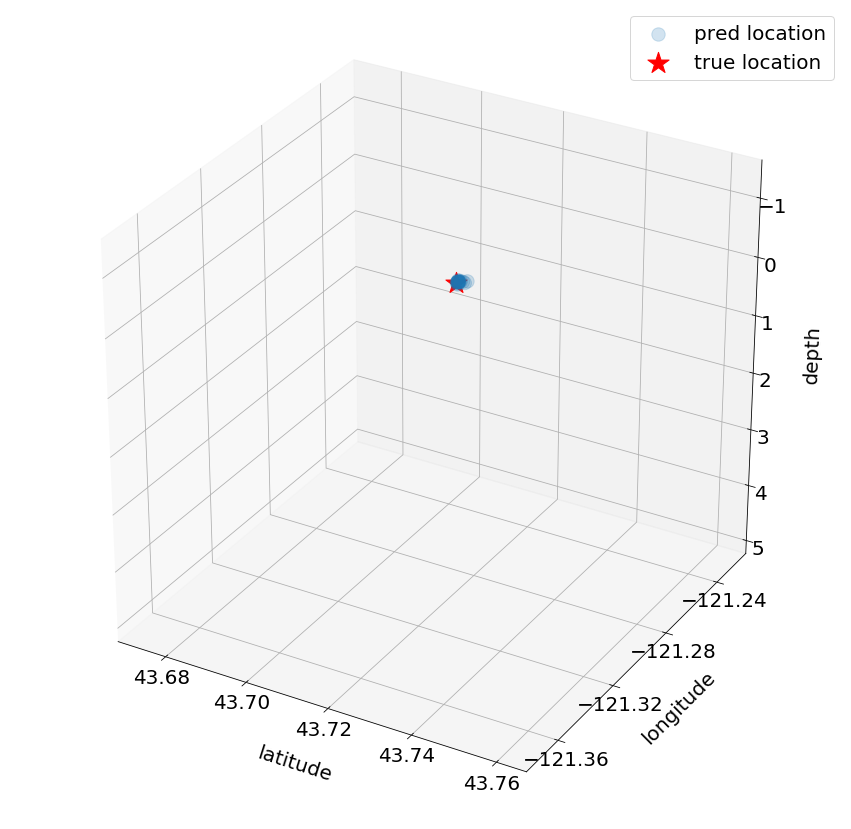

event120 location results_ZoomIn


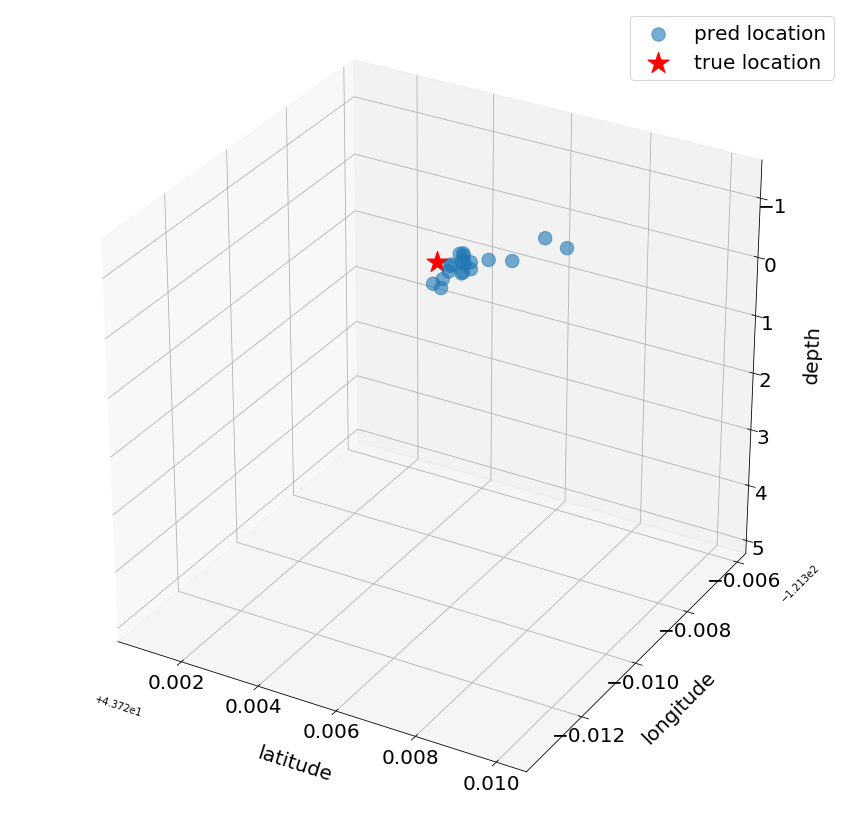

In [116]:
indexPlot = np.random.randint(149)
if indexPlot == 0:
    k = list(np.arange(0,7))
else:
    k = list(np.arange((indexPlot-1)*20 +7, indexPlot*20 +7))
srcPredPlot = srcDataTrue[k,:]
srcLabelPlot = srcLableTrue[k,:]
srcE, srcN, srcZ = srcLabelPlot[0,0], srcLabelPlot[0,1], srcLabelPlot[0,2]
font1 = {'weight': 'normal',
         'size': 20,
         }
# print(srcPredPlot, srcLabelPlot)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(srcPredPlot[:,0], srcPredPlot[:,1], srcPredPlot[:,2], s=180, marker='o',alpha = 0.2, label = 'pred location')
ax.scatter(srcLabelPlot[0,0], srcLabelPlot[0,1], srcLabelPlot[0,2], s=500, c = 'r', marker='*', label = 'true location')
ax.set_xlabel('latitude', font1, labelpad = 20)
ax.set_ylabel('longitude', font1, labelpad = 20)
ax.set_zlabel('depth', font1, labelpad = 20)
ax.set_xlim([lanMin, lanMax])
ax.set_ylim([lngMin, lngMax])
ax.set_zlim([dpthMax, dpthMin])
plt.legend(prop = font2, loc = 1)
ax.tick_params(axis='both', which='major', labelsize=20, pad = 0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.04))
figIndex = 'event' + str(indexPlot) + ' location results'
plt.savefig(figIndex, bbox_inches='tight', dpi=600)
print(figIndex)
plt.show()



fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(srcPredPlot[:,0], srcPredPlot[:,1], srcPredPlot[:,2], s=180, marker='o', alpha = 0.6, label = 'pred location')
ax.scatter(srcLabelPlot[0,0], srcLabelPlot[0,1], srcLabelPlot[0,2], s=500, c = 'r', marker='*', label = 'true location')
ax.set_xlabel('latitude', font1, labelpad = 20)
ax.set_ylabel('longitude', font1, labelpad = 20)
ax.set_zlabel('depth', font1, labelpad = 20)
ax.set_xlim([srcE - 0.005, srcE + 0.005])
ax.set_ylim([srcN - 0.004, srcN + 0.004])
ax.set_zlim([dpthMax, dpthMin])
plt.legend(prop = font2)
ax.tick_params(axis='both', which='major', labelsize=20, pad = 0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.002))
figIndex = 'event' + str(indexPlot) + ' location results_ZoomIn'
plt.savefig(figIndex, bbox_inches='tight', dpi=600)
print(figIndex)
plt.show()


In [35]:
np.savez('locationData0805.npz', srcPred = srcDataTrue, srcLable = srcLableTrue)

In [4]:
indexPlot = np.random.randint(149)
if indexPlot == 0:
    k = list(np.arange(0,7))
else:
    k = list(np.arange((indexPlot-1)*20 +7, indexPlot*20 +7))
srcPredPlot = srcPred[k,:]
srcLabelPlot = srcLableTrue[k,:]
srcE, srcN, srcZ = srcLabelPlot[0,0], srcLabelPlot[0,1], srcLabelPlot[0,2]
font1 = {'weight': 'normal',
         'size': 20,
         }
# plt.scatter(srcDataTrue[0:42,0], srcDataTrue[0:42,1])
fig = plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.scatter(srcPredPlot[k,0], srcPredPlot[k,1], s=20, marker='o',alpha = 0.4, label = 'pred locations')
plt.scatter(srcE, srcN, s=30, marker='*', label = 'true location')
plt.xlabel('lantitude')
plt.ylabel('longitude')
plt.title('lat-lng slice')
plt.legend()
plt.subplot(223)
plt.scatter(srcPredPlot[k,0], srcPredPlot[k,2], s=20, marker='o',alpha = 0.4, label = 'pred locations')
plt.scatter(srcE, srcZ, s=30, marker='*', label = 'true location')
plt.xlabel('lantitude')
plt.ylabel('depth')
plt.title('lat-depth slice')
plt.legend()
plt.subplot(224)
plt.scatter(srcPredPlot[k,1], srcPredPlot[k,2], s=20, marker='o',alpha = 0.4, label = 'pred locations')
plt.scatter(srcN, srcZ, s=30, marker='*', label = 'true location')
plt.xlabel('longitude')
plt.ylabel('depth')
plt.title('lng-depth slice')
plt.legend()
plt.show()


NameError: name 'srcDataTrue' is not defined

In [52]:
rStaTr = rSta[order_train,:]
rStaVal = rSta[order_val,:]
print(rStaTr.shape, rStaVal.shape)
srcTr = predTrain + rStaTr
srcVal = predVal + rStaVal

(16021, 3) (1781, 3)


In [81]:
errTr = predTrain - labelTrain - 1
errVal = predVal - labelVal - 1

In [82]:
np.max(errTr), np.max(errVal)
print(errTr, errVal)

[[-0.00464368 -0.00206453 -0.00132728]
 [-0.00797105 -0.00322419 -0.01096034]
 [-0.00367647 -0.00396806  0.00222445]
 ...
 [ 0.00649595  0.00558662  0.0001061 ]
 [-0.01168513 -0.00169528 -0.00147915]
 [ 0.01035357  0.00201881  0.00164425]] [[ 0.00569999  0.00343049  0.00306082]
 [-0.00131619 -0.01091564 -0.00162452]
 [ 0.00400901 -0.00480729  0.00075507]
 ...
 [ 0.00248146  0.00441849 -0.00155789]
 [ 0.00050521 -0.00378174  0.00062871]
 [-0.00166363  0.00086963  0.00023472]]


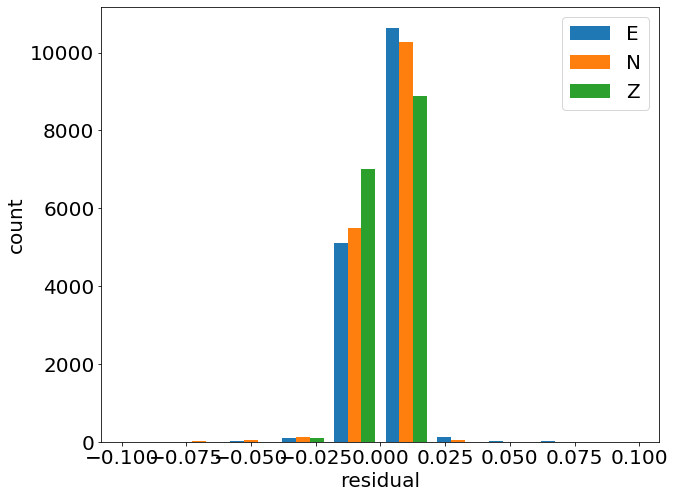

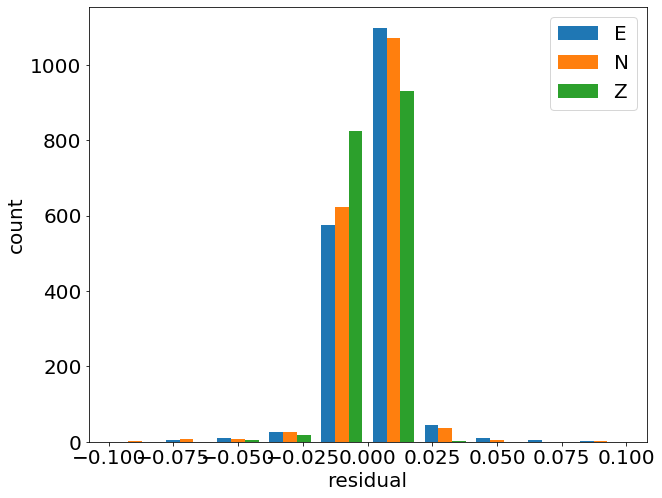

In [93]:

binrange = np.linspace(-0.1, 0.1, 11)
# print(binrange)

plt.figure(figsize=(10, 8))
plt.hist(errTr, bins = binrange, label = list('ENZ'))
plt.xlabel('residual', font2)
plt.ylabel('count', font2)
plt.tick_params(labelsize=20)
plt.legend(prop=font2)
plt.savefig('NewBerry error_distribution of training dataset', bbox_inches='tight', dpi=1000)
plt.show()

# bins = binrange, 

plt.figure(figsize=(10, 8))
plt.hist(errVal, bins = binrange, label = list('ENZ'))
plt.xlabel('residual', font2)
plt.ylabel('count', font2)
plt.tick_params(labelsize=20)
plt.legend(prop=font2)
plt.savefig('NewBerry error_distribution of validation dataset', bbox_inches='tight', dpi=1000)
plt.show()

In [41]:
rawdata_path = 'input_labelNewberry0730.npz'
dataAll = np.load(rawdata_path)
dataAllList = dataAll.files
print(dataAllList)
rLayoutData = dataAll[dataAllList[1]]
labelData = dataAll[dataAllList[2]]
# rData = dataAll[dataAllList[3]]
print(rLayoutData.shape)
print(labelData.shape)
# print(rData.shape)
# print((labelData + rTargetData[:,1:4])*modelGrid)

['input1', 'input2', 'label']
(17802, 6, 3)
(17802, 3)


In [30]:
rsVpredTrain = predTrain - 1
rsVpredVal = predVal - 1
rVector = rData.reshape(-1,3)
rVecTrain = rVector[order_train,:]
rVecVal = rVector[order_val,:]
labelTrain = labelData[order_train,:]
labelVal = labelData[order_val,:]
sTrueTrain = rVecTrain + labelTrain
sTrueVal = rVecVal + labelVal
sPredTrain = rVecTrain + rsVpredTrain
sPredVal = rVecVal + rsVpredVal